## ELETTRA-40: ID linear optics distortion (transparent ID)

In [1]:
# In this example the matched ID is inserted into the lattice
# Given an ID liner transport matrix parameterization exp(S A) with A diagonal and diag(A) = (a, b, c, d)
# The transparency condition (at a location where the alpha is zero) is bx = sqrt(b/a) and by = sqrt(d/c)
# However, for realistic ID parameters this leads to very small beta-function values (< 1 m) at the ID, which are not feasible

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix
from model.library.drift import Drift

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Change lattice start

ring.start = "MLL_S01"

# Describe

ring.describe

{'Marker': 12, 'Drift': 708, 'BPM': 168, 'Quadrupole': 360, 'Dipole': 156}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [7]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

axi, *_ = ax
bxi, *_ = bx
ayi, *_ = ay
byi, *_ = by

In [8]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

mux = mux.cumsum(-1)
muy = muy.cumsum(-1)

mux = (mux % mux.max()).roll(1)
muy = (muy % muy.max()).roll(1)

In [9]:
# Define rescaled ID

ca, cb, cc, cd = -0.034441907232402175, -0.04458009513208418, 0.056279356423643276, 0.08037110220505986

fx = bxi**2*ca/cb
fy = byi**2*cc/cd
ca, cb = ca/fx**0.5, cb*fx**0.5
cc, cd = cc/fy**0.5, cd*fy**0.5

A = torch.tensor([[ca, 0.0, 0.0, 0.0], [0.0, cb, 0.0, 0.0], [0.0, 0.0, cc, 0.0], [0.0, 0.0, 0.0, cd]], dtype=dtype)

mask = torch.triu(torch.ones_like(A, dtype=torch.bool))

Ax, Bx, _, _, Cx, _, _, Ay, By, Cy = A[mask].to(torch.complex128)

ID = Matrix('ID', length=0.0, A=(A[mask]).tolist())

In [10]:
# Replace marker by ID

ring.replace('MLL_S01', ID)

# Describe

ring.describe

{'Matrix': 1,
 'Drift': 708,
 'BPM': 168,
 'Quadrupole': 360,
 'Dipole': 156,
 'Marker': 11}

In [11]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(ring, [], matched=True, limit=1)

In [12]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(ring, [], matched=True, advance=True, full=False).T

axf, *_ = ax_id
bxf, *_ = bx_id
ayf, *_ = ay_id
byf, *_ = by_id

In [13]:
# Compute phase advances

mux_id, muy_id = advance(ring, [], alignment=False, matched=True).T

mux_id = mux_id.cumsum(-1)
muy_id = muy_id.cumsum(-1)

mux_id = (mux_id % mux_id.max()).roll(1)
muy_id = (muy_id % muy_id.max()).roll(1)

In [14]:
# Tune shifts

print(nux - nux_id)
print(nuy - nuy_id)

tensor(0.0062, dtype=torch.float64)
tensor(-0.0107, dtype=torch.float64)


In [15]:
# Tune shifts (exact)

def dnux(Ax, Bx, Cx, ax, bx, nux):
    return nux - torch.arccos(torch.cos(2*nux*torch.pi)*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx)) - ((Ax*bx**2 - 2*ax*bx*Bx + Cx + ax**2*Cx)*torch.sin(2*nux*torch.pi)*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx)))/(2*bx*torch.sqrt(Bx**2 - Ax*Cx)))/(2*torch.pi)

def dnuy(Ay, By, Cy, ay, by, nuy):
    return nuy - torch.arccos(torch.cos(2*nuy*torch.pi)*torch.cosh(torch.sqrt(By**2 - Ay*Cy)) - ((Ay*by**2 - 2*ay*by*By + Cy + ay**2*Cy)*torch.sin(2*nuy*torch.pi)*torch.sinh(torch.sqrt(By**2 - Ay*Cy)))/(2*by*torch.sqrt(By**2 - Ay*Cy)))/(2*torch.pi)

print((nux - nux_id))
print(dnux(Ax, Bx, Cx, axi, bxi, nux).real)
print()

print((nuy - nuy_id))
print(dnux(Ay, By, Cy, ayi, byi, nuy).real)
print()

tensor(0.0062, dtype=torch.float64)
tensor(0.0062, dtype=torch.float64)

tensor(-0.0107, dtype=torch.float64)
tensor(-0.0107, dtype=torch.float64)



In [16]:
# Tune shifts (approximate)

def dnux(Ax, Bx, Cx, ax, bx, nux):
    cx = (1 + ax**2)/bx
    return - ((Ax*bx - 2*ax*Bx + cx*Cx)/(4*torch.pi) - ((Ax**2*bx**2 - 4*ax*Ax*bx*Bx + 4*bx*Bx**2*cx + 2*Ax*(-2 + bx*cx)*Cx + cx*Cx*(-4*ax*Bx + cx*Cx))*torch.cos(2*nux*torch.pi)/torch.sin(2*nux*torch.pi))/(16*torch.pi))

def dnuy(Ay, By, Cy, ay, by, nuy):
    cy = (1 + ay**2)/by
    return - ((Ay*by - 2*ay*By + cy*Cy)/(4*torch.pi) - ((Ay**2*by**2 - 4*ay*Ay*by*By + 4*by*By**2*cy + 2*Ay*(-2 + by*cy)*Cy + cy*Cy*(-4*ay*By + cy*Cy))*torch.cos(2*nuy*torch.pi)/torch.sin(2*nuy*torch.pi))/(16*torch.pi))

print((nux - nux_id))
print(dnux(Ax, Bx, Cx, axi, bxi, nux).real)
print()

print((nuy - nuy_id))
print(dnux(Ay, By, Cy, ayi, byi, nuy).real)
print()

tensor(0.0062, dtype=torch.float64)
tensor(0.0062, dtype=torch.float64)

tensor(-0.0107, dtype=torch.float64)
tensor(-0.0107, dtype=torch.float64)



In [17]:
# Twiss at the observation point (exact)

def csx(Ax, Bx, Cx, ax, bx, nux):
    cx = (1 + ax**2)/bx
    hax = (2*ax*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx))*torch.sin(2*nux*torch.pi) + ((2*bx*Bx*torch.cos(2*nux*torch.pi) + (-(Ax*bx**2) + Cx + ax**2*Cx)*torch.sin(2*nux*torch.pi))*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx)))/(bx*torch.sqrt(Bx**2 - Ax*Cx)))/(2*torch.sqrt(1 - (torch.cos(2*nux*torch.pi)*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx)) - ((Ax*bx**2 - 2*ax*bx*Bx + Cx + ax**2*Cx)*torch.sin(2*nux*torch.pi)*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx)))/(2*bx*torch.sqrt(Bx**2 - Ax*Cx)))**2))    
    hbx = (bx*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx))*torch.sin(2*nux*torch.pi) + ((Cx*torch.cos(2*nux*torch.pi) + (-(bx*Bx) + ax*Cx)*torch.sin(2*nux*torch.pi))*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx)))/torch.sqrt(Bx**2 - Ax*Cx))/torch.sqrt(1 - (torch.cos(2*nux*torch.pi)*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx)) - ((Ax*bx**2 - 2*ax*bx*Bx + Cx + ax**2*Cx)*torch.sin(2*nux*torch.pi)*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx)))/(2*bx*torch.sqrt(Bx**2 - Ax*Cx)))**2)
    return torch.stack([hax, hbx])

def csy(Ay, By, Cy, ay, by, nuy):
    cy = (1 + ay**2)/by
    hay = (2*ay*torch.cosh(torch.sqrt(By**2 - Ay*Cy))*torch.sin(2*nuy*torch.pi) + ((2*by*By*torch.cos(2*nuy*torch.pi) + (-(Ay*by**2) + Cy + ay**2*Cy)*torch.sin(2*nuy*torch.pi))*torch.sinh(torch.sqrt(By**2 - Ay*Cy)))/(by*torch.sqrt(By**2 - Ay*Cy)))/(2*torch.sqrt(1 - (torch.cos(2*nuy*torch.pi)*torch.cosh(torch.sqrt(By**2 - Ay*Cy)) - ((Ay*by**2 - 2*ay*by*By + Cy + ay**2*Cy)*torch.sin(2*nuy*torch.pi)*torch.sinh(torch.sqrt(By**2 - Ay*Cy)))/(2*by*torch.sqrt(By**2 - Ay*Cy)))**2))    
    hby = (by*torch.cosh(torch.sqrt(By**2 - Ay*Cy))*torch.sin(2*nuy*torch.pi) + ((Cy*torch.cos(2*nuy*torch.pi) + (-(by*By) + ay*Cy)*torch.sin(2*nuy*torch.pi))*torch.sinh(torch.sqrt(By**2 - Ay*Cy)))/torch.sqrt(By**2 - Ay*Cy))/torch.sqrt(1 - (torch.cos(2*nuy*torch.pi)*torch.cosh(torch.sqrt(By**2 - Ay*Cy)) - ((Ay*by**2 - 2*ay*by*By + Cy + ay**2*Cy)*torch.sin(2*nuy*torch.pi)*torch.sinh(torch.sqrt(By**2 - Ay*Cy)))/(2*by*torch.sqrt(By**2 - Ay*Cy)))**2)
    return torch.stack([hay, hby])

print(torch.stack([axf, bxf]))
print(csx(Ax, Bx, Cx, axi, bxi, nux).real)
print()

print(torch.stack([ayf, byf]))
print(csy(Ay, By, Cy, ayi, byi, nuy).real)
print()

tensor([-7.2024e-15,  9.4152e+00], dtype=torch.float64)
tensor([-7.1968e-15,  9.4152e+00], dtype=torch.float64)

tensor([-2.8043e-15,  1.6398e+00], dtype=torch.float64)
tensor([-2.8375e-15,  1.6398e+00], dtype=torch.float64)



In [18]:
# Twiss at the observation point (approximate)

def csx(Ax, Bx, Cx, ax, bx, nux):
    cx = (1 + ax**2)/bx
    hax = ax + (-(Ax*bx) + cx*Cx - (ax*Ax*bx - 2*bx*Bx*cx + ax*cx*Cx)*(torch.cos(2*nux*torch.pi)/torch.sin(2*nux*torch.pi)))/2.0 + ((1.0/torch.sin(2*nux*torch.pi)**3)*(16*ax*(Bx**2 - Ax*Cx)*torch.sin(2*nux*torch.pi)**3 + 4*ax*torch.sin(2*nux*torch.pi)*(4*(Bx**2 - Ax*Cx)*torch.cos(2*nux*torch.pi)**2 + (Ax*bx - 2*ax*Bx + cx*Cx)**2 * torch.sin(2*nux*torch.pi)**2) + 4*(Ax*bx - 2*ax*Bx + cx*Cx)*(-2*Bx*torch.cos(2*nux*torch.pi) + (Ax*bx - cx*Cx)*torch.sin(2*nux*torch.pi))*torch.sin(4*nux*torch.pi) + 3*ax*(Ax*bx - 2*ax*Bx + cx*Cx)**2*(1.0/torch.sin(2*nux*torch.pi)) * torch.sin(4*nux*torch.pi)**2))/32.0
    hbx = bx - bx*Bx + ax*Cx + (-0.5*(Ax*bx**2) + ax*bx*Bx + Cx - 0.5*(bx*cx*Cx)) * (torch.cos(2*nux*torch.pi)/torch.sin(2*nux*torch.pi)) + (4*bx*(Bx**2 - Ax*Cx) + bx*(Ax*bx - 2*ax*Bx + cx*Cx)**2 + 4*bx*(Bx**2 - Ax*Cx)*(torch.cos(2*nux*torch.pi)/torch.sin(2*nux*torch.pi))**2 + 3*bx*(Ax*bx - 2*ax*Bx + cx*Cx)**2*(torch.cos(2*nux*torch.pi)/torch.sin(2*nux*torch.pi))**2 + 2*(Ax*bx - 2*ax*Bx + cx*Cx)*(bx*Bx - ax*Cx - Cx*(torch.cos(2*nux*torch.pi)/torch.sin(2*nux*torch.pi)))*(1.0/torch.sin(2*nux*torch.pi)**2) * torch.sin(4*nux*torch.pi))/8.0
    return torch.stack([hax, hbx])

def csy(Ay, By, Cy, ay, by, nuy):
    cy = (1 + ay**2)/by
    hay = ay + (-(Ay*by) + cy*Cy - (ay*Ay*by - 2*by*By*cy + ay*cy*Cy)*(torch.cos(2*nuy*torch.pi)/torch.sin(2*nuy*torch.pi)))/2.0 + ((1.0/torch.sin(2*nuy*torch.pi)**3)*(16*ay*(By**2 - Ay*Cy)*torch.sin(2*nuy*torch.pi)**3 + 4*ay*torch.sin(2*nuy*torch.pi)*(4*(By**2 - Ay*Cy)*torch.cos(2*nuy*torch.pi)**2 + (Ay*by - 2*ay*By + cy*Cy)**2 * torch.sin(2*nuy*torch.pi)**2) + 4*(Ay*by - 2*ay*By + cy*Cy)*(-2*By*torch.cos(2*nuy*torch.pi) + (Ay*by - cy*Cy)*torch.sin(2*nuy*torch.pi))*torch.sin(4*nuy*torch.pi) + 3*ay*(Ay*by - 2*ay*By + cy*Cy)**2*(1.0/torch.sin(2*nuy*torch.pi)) * torch.sin(4*nuy*torch.pi)**2))/32.0
    hby = by - by*By + ay*Cy + (-0.5*(Ay*by**2) + ay*by*By + Cy - 0.5*(by*cy*Cy)) * (torch.cos(2*nuy*torch.pi)/torch.sin(2*nuy*torch.pi)) + (4*by*(By**2 - Ay*Cy) + by*(Ay*by - 2*ay*By + cy*Cy)**2 + 4*by*(By**2 - Ay*Cy)*(torch.cos(2*nuy*torch.pi)/torch.sin(2*nuy*torch.pi))**2 + 3*by*(Ay*by - 2*ay*By + cy*Cy)**2*(torch.cos(2*nuy*torch.pi)/torch.sin(2*nuy*torch.pi))**2 + 2*(Ay*by - 2*ay*By + cy*Cy)*(by*By - ay*Cy - Cy*(torch.cos(2*nuy*torch.pi)/torch.sin(2*nuy*torch.pi)))*(1.0/torch.sin(2*nuy*torch.pi)**2) * torch.sin(4*nuy*torch.pi))/8.0
    return torch.stack([hay, hby])

print(torch.stack([axf, bxf]))
print(csx(Ax, Bx, Cx, axi, bxi, nux).real)
print()

print(torch.stack([ayf, byf]))
print(csy(Ay, By, Cy, ayi, byi, nuy).real)
print()

tensor([-7.2024e-15,  9.4152e+00], dtype=torch.float64)
tensor([-7.2003e-15,  9.4152e+00], dtype=torch.float64)

tensor([-2.8043e-15,  1.6398e+00], dtype=torch.float64)
tensor([-2.8364e-15,  1.6398e+00], dtype=torch.float64)



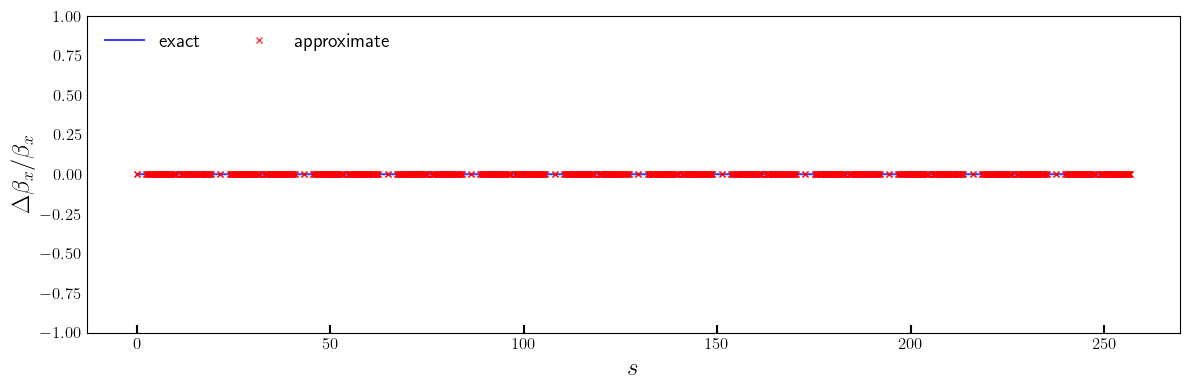

tensor(4.6202e-12, dtype=torch.float64)
tensor(4.6143e-14, dtype=torch.float64)


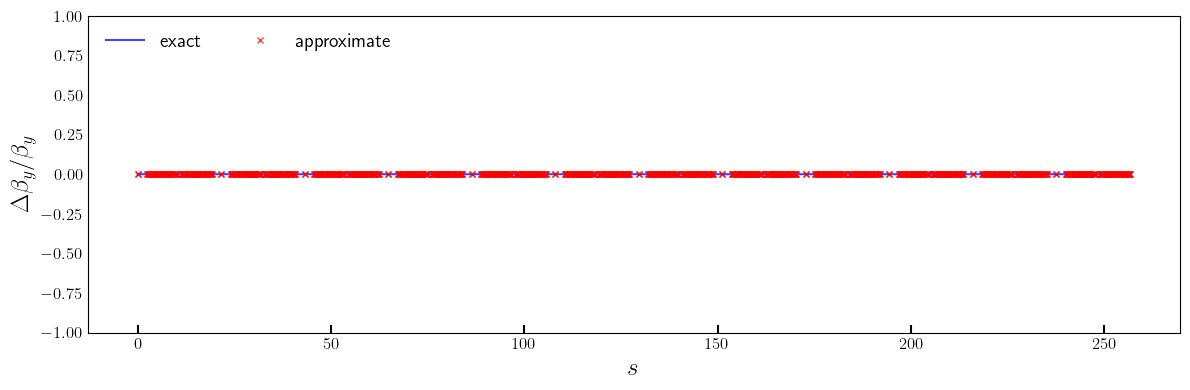

tensor(4.3448e-11, dtype=torch.float64)
tensor(2.6894e-14, dtype=torch.float64)


In [19]:
# Beta beating (exact)

def bbx(Ax, Bx, Cx, nux, ax, bx, axs, bxs, mux):
    bxf = (bxs*(8*bx**2*(Bx**2 - Ax*Cx)*(torch.cos(2*mux) - torch.cos(4*nux*torch.pi))*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx))**4 + 16*bx**2*(Bx**2 - Ax*Cx)*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx))**2*torch.sin(mux)**2 + 8*bx*torch.sqrt(Bx**2 - Ax*Cx)*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx))**3*(-4*Cx*torch.cos(mux)*torch.cos(2*nux*torch.pi) + 2*torch.sin(mux)*(2*(bx*Bx - ax*Cx)*torch.cos(2*nux*torch.pi) + (Ax*bx**2 - 2*ax*bx*Bx + Cx + ax**2*Cx)*torch.sin(2*nux*torch.pi)))*torch.sin(mux - 2*nux*torch.pi)*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx)) + 16*(Cx*torch.cos(mux) + (-(bx*Bx) + ax*Cx)*torch.sin(mux))**2*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx))**2 - 8*bx*torch.sqrt(Bx**2 - Ax*Cx)*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx))*(-4*Cx*torch.cos(mux)*torch.cos(2*nux*torch.pi) + 2*torch.sin(mux)*(2*(bx*Bx - ax*Cx)*torch.cos(2*nux*torch.pi) + (Ax*bx**2 - 2*ax*bx*Bx + Cx + ax**2*Cx)*torch.sin(2*nux*torch.pi)))*torch.sin(mux - 2*nux*torch.pi)*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx))**3 - 16*(-(bx**2*(Bx**2 - Ax*Cx)*torch.cos(nux*torch.pi)**2*torch.sin(mux)) + torch.sin(mux)*torch.sin(nux*torch.pi)*(-2*(bx*Bx - ax*Cx)*(Ax*bx**2 - 2*ax*bx*Bx + Cx + ax**2*Cx)*torch.cos(nux*torch.pi) + bx**2*(Bx**2 - Ax*Cx)*torch.sin(nux*torch.pi)) + (bx**2*Bx**2 - 2*ax*bx*Bx*Cx + (1 + ax**2)*Cx**2)*torch.cos(mux)*torch.sin(2*nux*torch.pi))*torch.sin(mux - 2*nux*torch.pi)*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx))**4 + torch.sinh(2*torch.sqrt(Bx**2 - Ax*Cx))*(-16*bx*torch.sqrt(Bx**2 - Ax*Cx)*torch.sin(mux)*(-(Cx*torch.cos(mux)) + (bx*Bx - ax*Cx)*torch.sin(mux)) - 4*(-((-2*ax*bx*Bx*Cx + (1 + ax**2)*Cx**2 + bx**2*(2*Bx**2 - Ax*Cx))*torch.cos(mux)) + (bx*Bx - ax*Cx)*(Ax*bx**2 - 2*ax*bx*Bx + Cx + ax**2*Cx)*torch.sin(mux))*torch.sin(2*nux*torch.pi)*torch.sin(mux - 2*nux*torch.pi)*torch.sinh(2*torch.sqrt(Bx**2 - Ax*Cx)))))/(8*bx*torch.sqrt(Bx**2 - Ax*Cx)*(bx*torch.sqrt(Bx**2 - Ax*Cx)*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx))*torch.sin(2*nux*torch.pi) + (Cx*torch.cos(2*nux*torch.pi) + (-(bx*Bx) + ax*Cx)*torch.sin(2*nux*torch.pi))*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx)))*torch.sqrt((-4*bx**2*(Bx**2 - Ax*Cx)*torch.cos(2*nux*torch.pi)**2*torch.cosh(torch.sqrt(Bx**2 - Ax*Cx))**2 - (Ax*bx**2 - 2*ax*bx*Bx + Cx + ax**2*Cx)**2*torch.sin(2*nux*torch.pi)**2*torch.sinh(torch.sqrt(Bx**2 - Ax*Cx))**2 + bx*(4*bx*(Bx**2 - Ax*Cx) - (-(Ax*bx**2) + 2*ax*bx*Bx - Cx - ax**2*Cx)*torch.sqrt(Bx**2 - Ax*Cx)*torch.sin(4*nux*torch.pi)*torch.sinh(2*torch.sqrt(Bx**2 - Ax*Cx))))/(bx**2*(Bx**2 - Ax*Cx))))
    return (100*(bxf - bxs)/bxs).real

def bby(Ay, By, Cy, nuy, ay, by, ays, bys, muy):
    byf = (bys*(8*by**2*(By**2 - Ay*Cy)*(torch.cos(2*muy) - torch.cos(4*nuy*torch.pi))*torch.cosh(torch.sqrt(By**2 - Ay*Cy))**4 + 16*by**2*(By**2 - Ay*Cy)*torch.cosh(torch.sqrt(By**2 - Ay*Cy))**2*torch.sin(muy)**2 + 8*by*torch.sqrt(By**2 - Ay*Cy)*torch.cosh(torch.sqrt(By**2 - Ay*Cy))**3*(-4*Cy*torch.cos(muy)*torch.cos(2*nuy*torch.pi) + 2*torch.sin(muy)*(2*(by*By - ay*Cy)*torch.cos(2*nuy*torch.pi) + (Ay*by**2 - 2*ay*by*By + Cy + ay**2*Cy)*torch.sin(2*nuy*torch.pi)))*torch.sin(muy - 2*nuy*torch.pi)*torch.sinh(torch.sqrt(By**2 - Ay*Cy)) + 16*(Cy*torch.cos(muy) + (-(by*By) + ay*Cy)*torch.sin(muy))**2*torch.sinh(torch.sqrt(By**2 - Ay*Cy))**2 - 8*by*torch.sqrt(By**2 - Ay*Cy)*torch.cosh(torch.sqrt(By**2 - Ay*Cy))*(-4*Cy*torch.cos(muy)*torch.cos(2*nuy*torch.pi) + 2*torch.sin(muy)*(2*(by*By - ay*Cy)*torch.cos(2*nuy*torch.pi) + (Ay*by**2 - 2*ay*by*By + Cy + ay**2*Cy)*torch.sin(2*nuy*torch.pi)))*torch.sin(muy - 2*nuy*torch.pi)*torch.sinh(torch.sqrt(By**2 - Ay*Cy))**3 - 16*(-(by**2*(By**2 - Ay*Cy)*torch.cos(nuy*torch.pi)**2*torch.sin(muy)) + torch.sin(muy)*torch.sin(nuy*torch.pi)*(-2*(by*By - ay*Cy)*(Ay*by**2 - 2*ay*by*By + Cy + ay**2*Cy)*torch.cos(nuy*torch.pi) + by**2*(By**2 - Ay*Cy)*torch.sin(nuy*torch.pi)) + (by**2*By**2 - 2*ay*by*By*Cy + (1 + ay**2)*Cy**2)*torch.cos(muy)*torch.sin(2*nuy*torch.pi))*torch.sin(muy - 2*nuy*torch.pi)*torch.sinh(torch.sqrt(By**2 - Ay*Cy))**4 + torch.sinh(2*torch.sqrt(By**2 - Ay*Cy))*(-16*by*torch.sqrt(By**2 - Ay*Cy)*torch.sin(muy)*(-(Cy*torch.cos(muy)) + (by*By - ay*Cy)*torch.sin(muy)) - 4*(-((-2*ay*by*By*Cy + (1 + ay**2)*Cy**2 + by**2*(2*By**2 - Ay*Cy))*torch.cos(muy)) + (by*By - ay*Cy)*(Ay*by**2 - 2*ay*by*By + Cy + ay**2*Cy)*torch.sin(muy))*torch.sin(2*nuy*torch.pi)*torch.sin(muy - 2*nuy*torch.pi)*torch.sinh(2*torch.sqrt(By**2 - Ay*Cy)))))/(8*by*torch.sqrt(By**2 - Ay*Cy)*(by*torch.sqrt(By**2 - Ay*Cy)*torch.cosh(torch.sqrt(By**2 - Ay*Cy))*torch.sin(2*nuy*torch.pi) + (Cy*torch.cos(2*nuy*torch.pi) + (-(by*By) + ay*Cy)*torch.sin(2*nuy*torch.pi))*torch.sinh(torch.sqrt(By**2 - Ay*Cy)))*torch.sqrt((-4*by**2*(By**2 - Ay*Cy)*torch.cos(2*nuy*torch.pi)**2*torch.cosh(torch.sqrt(By**2 - Ay*Cy))**2 - (Ay*by**2 - 2*ay*by*By + Cy + ay**2*Cy)**2*torch.sin(2*nuy*torch.pi)**2*torch.sinh(torch.sqrt(By**2 - Ay*Cy))**2 + by*(4*by*(By**2 - Ay*Cy) - (-(Ay*by**2) + 2*ay*by*By - Cy - ay**2*Cy)*torch.sqrt(By**2 - Ay*Cy)*torch.sin(4*nuy*torch.pi)*torch.sinh(2*torch.sqrt(By**2 - Ay*Cy))))/(by**2*(By**2 - Ay*Cy))))
    return (100*(byf - bys)/bys).real

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', ms=0, color='blue', alpha=0.75, label='exact')
plt.errorbar(ring.locations().cpu().numpy(), -bbx(Ax, Bx, Cx, nux, axi, bxi, ax, bx, mux), fmt=' ', marker='x', ms=5, color='red', alpha=0.75, label='approximate')

plt.gca().tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
plt.gca().tick_params(axis='y', length=0, width=0, labelsize=12)
plt.gca().set_xlabel(r'$s$', fontsize=18)
plt.gca().set_ylabel(r'$\Delta \beta_x / \beta_x$', fontsize=18)
plt.legend(loc='upper left', frameon=False, fontsize=14, ncol=2)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print((bbx(Ax, Bx, Cx, nux, axi, bxi, ax, bx, mux)**2).mean().sqrt())

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', ms=0, color='blue', alpha=0.75, label='exact')
plt.errorbar(ring.locations().cpu().numpy(), -bby(Ay, By, Cy, nuy, ayi, byi, ay, by, muy), fmt=' ', marker='x', ms=5, color='red', alpha=0.75, label='approximate')
plt.gca().tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
plt.gca().tick_params(axis='y', length=0, width=0, labelsize=12)
plt.gca().set_xlabel(r'$s$', fontsize=18)
plt.gca().set_ylabel(r'$\Delta \beta_y / \beta_y$', fontsize=18)
plt.legend(loc='upper left', frameon=False, fontsize=14, ncol=2)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

print(100*(((by - by_id)/by)**2).mean().sqrt())
print((bby(Ay, By, Cy, nuy, ayi, byi, ay, by, muy)**2).mean().sqrt())

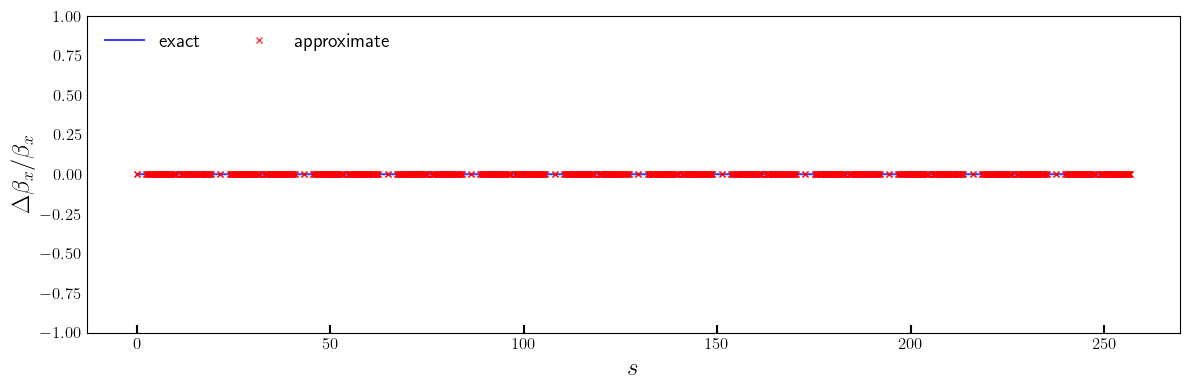

tensor(4.6202e-12, dtype=torch.float64)
tensor(2.1767e-14, dtype=torch.float64)


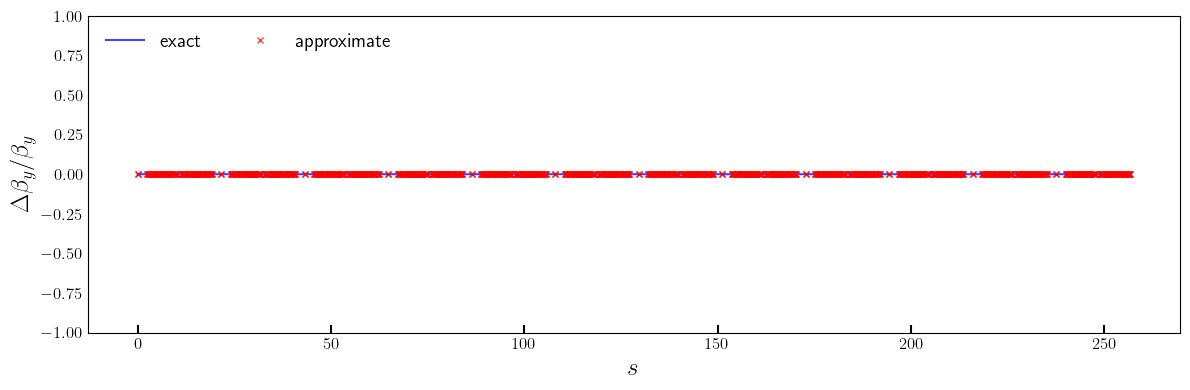

tensor(4.3448e-11, dtype=torch.float64)
tensor(1.5944e-14, dtype=torch.float64)


In [20]:
# Beta beating (approximate)

def bbx(Ax, Bx, Cx, nux, ax, bx, axs, bxs, mux):
    t = 1.0
    cx = (1 + ax**2)/bx
    bxf = bxs + (bxs*t**2*(1.0/torch.sin(2*nux*torch.pi)**2)*(4*ax*Bx*Cx*(torch.cos(2*mux) + torch.cos(2*mux - 4*nux*torch.pi)) - 2*cx*Cx**2*(torch.cos(2*mux) + torch.cos(2*mux - 4*nux*torch.pi)) + Ax**2*bx**3*(1 + torch.cos(2*mux) + torch.cos(2*mux - 4*nux*torch.pi)) - 4*ax*Ax*bx**2*Bx*(1 + torch.cos(2*mux) + torch.cos(2*mux - 4*nux*torch.pi)) - 4*ax*bx*Bx*cx*Cx*(1 + torch.cos(2*mux) + torch.cos(2*mux - 4*nux*torch.pi)) + bx*cx**2*Cx**2*(1 + torch.cos(2*mux) + torch.cos(2*mux - 4*nux*torch.pi)) + 2*bx**2*cx*(2*Bx**2 + Ax*Cx)*(1 + torch.cos(2*mux) + torch.cos(2*mux - 4*nux*torch.pi)) - 2*bx*(2*Ax*Cx + (2*Bx**2 + Ax*Cx)*torch.cos(2*mux) + (2*Bx**2 + Ax*Cx)*torch.cos(2*mux - 4*nux*torch.pi)) - 4*Bx*Cx*torch.sin(2*mux) - 4*Bx*Cx*torch.sin(2*mux - 4*nux*torch.pi) + 2*Ax*bx**2*Bx*(torch.sin(2*mux) + torch.sin(2*mux - 4*nux*torch.pi)) + 6*bx*Bx*cx*Cx*(torch.sin(2*mux) + torch.sin(2*mux - 4*nux*torch.pi)) - 2*ax*cx*Cx**2*(torch.sin(2*mux) + torch.sin(2*mux - 4*nux*torch.pi)) - 2*ax*bx*(2*Bx**2 + Ax*Cx)*(torch.sin(2*mux) + torch.sin(2*mux - 4*nux*torch.pi))))/(8*bx) - (bxs*t*(1.0/torch.sin(2*nux*torch.pi))*((Ax*bx**2 - 2*ax*bx*Bx - 2*Cx + bx*cx*Cx)*torch.cos(2*mux - 2*nux*torch.pi) + 2*(bx*Bx - ax*Cx)*torch.sin(2*mux - 2*nux*torch.pi)))/(2*bx)
    return (100*(bxf - bxs)/bxs).real

def bby(Ay, By, Cy, nuy, ay, by, ays, bys, muy):
    t = 1.0
    cy = (1 + ay**2)/by
    byf = bys + (bys*t**2*(1.0/torch.sin(2*nuy*torch.pi)**2)*(4*ay*By*Cy*(torch.cos(2*muy) + torch.cos(2*muy - 4*nuy*torch.pi)) - 2*cy*Cy**2*(torch.cos(2*muy) + torch.cos(2*muy - 4*nuy*torch.pi)) + Ay**2*by**3*(1 + torch.cos(2*muy) + torch.cos(2*muy - 4*nuy*torch.pi)) - 4*ay*Ay*by**2*By*(1 + torch.cos(2*muy) + torch.cos(2*muy - 4*nuy*torch.pi)) - 4*ay*by*By*cy*Cy*(1 + torch.cos(2*muy) + torch.cos(2*muy - 4*nuy*torch.pi)) + by*cy**2*Cy**2*(1 + torch.cos(2*muy) + torch.cos(2*muy - 4*nuy*torch.pi)) + 2*by**2*cy*(2*By**2 + Ay*Cy)*(1 + torch.cos(2*muy) + torch.cos(2*muy - 4*nuy*torch.pi)) - 2*by*(2*Ay*Cy + (2*By**2 + Ay*Cy)*torch.cos(2*muy) + (2*By**2 + Ay*Cy)*torch.cos(2*muy - 4*nuy*torch.pi)) - 4*By*Cy*torch.sin(2*muy) - 4*By*Cy*torch.sin(2*muy - 4*nuy*torch.pi) + 2*Ay*by**2*By*(torch.sin(2*muy) + torch.sin(2*muy - 4*nuy*torch.pi)) + 6*by*By*cy*Cy*(torch.sin(2*muy) + torch.sin(2*muy - 4*nuy*torch.pi)) - 2*ay*cy*Cy**2*(torch.sin(2*muy) + torch.sin(2*muy - 4*nuy*torch.pi)) - 2*ay*by*(2*By**2 + Ay*Cy)*(torch.sin(2*muy) + torch.sin(2*muy - 4*nuy*torch.pi))))/(8*by) - (bys*t*(1.0/torch.sin(2*nuy*torch.pi))*((Ay*by**2 - 2*ay*by*By - 2*Cy + by*cy*Cy)*torch.cos(2*muy - 2*nuy*torch.pi) + 2*(by*By - ay*Cy)*torch.sin(2*muy - 2*nuy*torch.pi)))/(2*by)
    return (100*(byf - bys)/bys).real

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', ms=0, color='blue', alpha=0.75, label='exact')
plt.errorbar(ring.locations().cpu().numpy(), -bbx(Ax, Bx, Cx, nux, axi, bxi, ax, bx, mux), fmt=' ', marker='x', ms=5, color='red', alpha=0.75, label='approximate')

plt.gca().tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
plt.gca().tick_params(axis='y', length=0, width=0, labelsize=12)
plt.gca().set_xlabel(r'$s$', fontsize=18)
plt.gca().set_ylabel(r'$\Delta \beta_x / \beta_x$', fontsize=18)
plt.legend(loc='upper left', frameon=False, fontsize=14, ncol=2)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print((bbx(Ax, Bx, Cx, nux, axi, bxi, ax, bx, mux)**2).mean().sqrt())

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', ms=0, color='blue', alpha=0.75, label='exact')
plt.errorbar(ring.locations().cpu().numpy(), -bby(Ay, By, Cy, nuy, ayi, byi, ay, by, muy), fmt=' ', marker='x', ms=5, color='red', alpha=0.75, label='approximate')
plt.gca().tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
plt.gca().tick_params(axis='y', length=0, width=0, labelsize=12)
plt.gca().set_xlabel(r'$s$', fontsize=18)
plt.gca().set_ylabel(r'$\Delta \beta_y / \beta_y$', fontsize=18)
plt.legend(loc='upper left', frameon=False, fontsize=14, ncol=2)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

print(100*(((by - by_id)/by)**2).mean().sqrt())
print((bby(Ay, By, Cy, nuy, ayi, byi, ay, by, muy)**2).mean().sqrt())

In [21]:
# Analytical RMS beta-beting

def rmsx(Ax, Bx, Cx, ax, bx, nux):
    cx = (1 + ax**2)/bx
    return 100*(((1.0/torch.sin(2*nux*torch.pi)**4)*((Ax**4*bx**6 + 16*bx**4*Bx**4*cx**2 - 4*Ax**3*bx**4*(2*ax*bx*Bx + Cx - bx*cx*Cx) - 8*bx**3*Bx**2*cx*(4*Bx**2 + 4*ax*Bx*cx*Cx - cx**2*Cx**2) + 4*(1 + ax**2)*Cx**2*(-4 + 4*Bx**2 + cx**2*Cx**2) - 4*bx*cx*Cx**2*(-4 + 4*(2 + ax**2)*Bx**2 + cx**2*Cx**2) + 2*Ax**2*bx**2*(4*bx**3*Bx**2*cx + 2*(1 + ax**2)*Cx**2 + 2*bx*Cx*(4*ax*Bx - 3*cx*Cx) + bx**2*(-2 + (-2 + 8*ax**2)*Bx**2 - 12*ax*Bx*cx*Cx + 3*cx**2*Cx**2)) + bx**2*(16*(1 + ax**2)*Bx**4 + 16*ax*Bx**3*cx*Cx + cx**2*Cx**2*(-4 + cx**2*Cx**2) - 8*ax*Bx*cx*Cx*(-2 + cx**2*Cx**2) + 4*Bx**2*(-4 + 3*cx**2*Cx**2 + 4*ax**2*(-1 + cx**2*Cx**2))) + 4*Ax*bx*(2*ax**2*Cx*(-2*bx*Bx**2 + 4*bx**2*Bx**2*cx + cx*Cx**2) + 2*ax*bx*Bx*(-4*bx**2*Bx**2*cx + 2*cx*Cx**2 + bx*(2 + 2*Bx**2 - 3*cx**2*Cx**2)) + Cx*(4*bx**3*Bx**2*cx**2 + 2*cx*Cx**2 + bx*(4 - 3*cx**2*Cx**2) + bx**2*cx*(-2 - 2*Bx**2 + cx**2*Cx**2))))*torch.cos(4*nux*torch.pi) + 2*(Ax**4*bx**6 + 8*bx**2*Bx**2 + 8*ax**2*bx**2*Bx**2 + 8*bx**2*Bx**4 + 8*ax**2*bx**2*Bx**4 - 16*bx**3*Bx**4*cx + 16*bx**4*Bx**4*cx**2 - 8*ax*bx**2*Bx*cx*Cx + 8*ax*bx**2*Bx**3*cx*Cx - 32*ax*bx**3*Bx**3*cx**2*Cx + 8*Cx**2 + 8*ax**2*Cx**2 + 8*Bx**2*Cx**2 + 8*ax**2*Bx**2*Cx**2 - 8*bx*cx*Cx**2 - 16*bx*Bx**2*cx*Cx**2 - 8*ax**2*bx*Bx**2*cx*Cx**2 + 2*bx**2*cx**2*Cx**2 + 6*bx**2*Bx**2*cx**2*Cx**2 + 16*ax**2*bx**2*Bx**2*cx**2*Cx**2 + 8*bx**3*Bx**2*cx**3*Cx**2 - 8*ax*bx**2*Bx*cx**3*Cx**3 + 2*cx**2*Cx**4 + 2*ax**2*cx**2*Cx**4 - 2*bx*cx**3*Cx**4 + bx**2*cx**4*Cx**4 - 2*Ax**3*bx**4*(4*ax*bx*Bx + (3 - 2*bx*cx)*Cx) + 2*Ax**2*bx**2*(4*bx**3*Bx**2*cx + (5 + ax**2)*Cx**2 + bx*Cx*(12*ax*Bx - 7*cx*Cx) + bx**2*(1 + (-1 + 8*ax**2)*Bx**2 - 12*ax*Bx*cx*Cx + 3*cx**2*Cx**2)) + 2*Ax*bx*(2*ax**2*Cx*(-2*bx*Bx**2 + 8*bx**2*Bx**2*cx + cx*Cx**2) - 4*ax*bx*Bx*(bx - bx*Bx**2 + 4*bx**2*Bx**2*cx - 3*cx*Cx**2 + 3*bx*cx**2*Cx**2) + Cx*(8*bx**3*Bx**2*cx**2 + 2*cx*Cx**2 - bx*(4 + 5*cx**2*Cx**2) + 2*bx**2*(cx - 5*Bx**2*cx + cx**3*Cx**2))) - 2*(Ax**3*bx**5 + Ax**2*bx**3*(-6*ax*bx*Bx + (-4 + 3*bx*cx)*Cx) + Ax*bx*(4*bx**3*Bx**2*cx + 4*ax*bx*Bx*(2 - 3*bx*cx)*Cx + 4*Cx**2 - 8*bx*cx*Cx**2 + 3*bx**2*cx**2*Cx**2 + 4*ax**2*(2*bx**2*Bx**2 + Cx**2)) + cx*(4*bx**3*Bx**2*cx*Cx + 4*Cx**3 - 4*bx*cx*Cx**3 + bx**2*cx**2*Cx**3 - 2*ax*bx**2*Bx*(4*bx*Bx**2 + 3*cx*Cx**2) + 4*ax**2*(2*bx**2*Bx**2*Cx + Cx**3)))*torch.sin(4*nux*torch.pi))))/(64*bx**2)).sqrt()

def rmsy(Ay, By, Cy, ay, by, nuy):
    cy = (1 + ay**2)/by
    return 100*(((1.0/torch.sin(2*nuy*torch.pi)**4)*((Ay**4*by**6 + 16*by**4*By**4*cy**2 - 4*Ay**3*by**4*(2*ay*by*By + Cy - by*cy*Cy) - 8*by**3*By**2*cy*(4*By**2 + 4*ay*By*cy*Cy - cy**2*Cy**2) + 4*(1 + ay**2)*Cy**2*(-4 + 4*By**2 + cy**2*Cy**2) - 4*by*cy*Cy**2*(-4 + 4*(2 + ay**2)*By**2 + cy**2*Cy**2) + 2*Ay**2*by**2*(4*by**3*By**2*cy + 2*(1 + ay**2)*Cy**2 + 2*by*Cy*(4*ay*By - 3*cy*Cy) + by**2*(-2 + (-2 + 8*ay**2)*By**2 - 12*ay*By*cy*Cy + 3*cy**2*Cy**2)) + by**2*(16*(1 + ay**2)*By**4 + 16*ay*By**3*cy*Cy + cy**2*Cy**2*(-4 + cy**2*Cy**2) - 8*ay*By*cy*Cy*(-2 + cy**2*Cy**2) + 4*By**2*(-4 + 3*cy**2*Cy**2 + 4*ay**2*(-1 + cy**2*Cy**2))) + 4*Ay*by*(2*ay**2*Cy*(-2*by*By**2 + 4*by**2*By**2*cy + cy*Cy**2) + 2*ay*by*By*(-4*by**2*By**2*cy + 2*cy*Cy**2 + by*(2 + 2*By**2 - 3*cy**2*Cy**2)) + Cy*(4*by**3*By**2*cy**2 + 2*cy*Cy**2 + by*(4 - 3*cy**2*Cy**2) + by**2*cy*(-2 - 2*By**2 + cy**2*Cy**2))))*torch.cos(4*nuy*torch.pi) + 2*(Ay**4*by**6 + 8*by**2*By**2 + 8*ay**2*by**2*By**2 + 8*by**2*By**4 + 8*ay**2*by**2*By**4 - 16*by**3*By**4*cy + 16*by**4*By**4*cy**2 - 8*ay*by**2*By*cy*Cy + 8*ay*by**2*By**3*cy*Cy - 32*ay*by**3*By**3*cy**2*Cy + 8*Cy**2 + 8*ay**2*Cy**2 + 8*By**2*Cy**2 + 8*ay**2*By**2*Cy**2 - 8*by*cy*Cy**2 - 16*by*By**2*cy*Cy**2 - 8*ay**2*by*By**2*cy*Cy**2 + 2*by**2*cy**2*Cy**2 + 6*by**2*By**2*cy**2*Cy**2 + 16*ay**2*by**2*By**2*cy**2*Cy**2 + 8*by**3*By**2*cy**3*Cy**2 - 8*ay*by**2*By*cy**3*Cy**3 + 2*cy**2*Cy**4 + 2*ay**2*cy**2*Cy**4 - 2*by*cy**3*Cy**4 + by**2*cy**4*Cy**4 - 2*Ay**3*by**4*(4*ay*by*By + (3 - 2*by*cy)*Cy) + 2*Ay**2*by**2*(4*by**3*By**2*cy + (5 + ay**2)*Cy**2 + by*Cy*(12*ay*By - 7*cy*Cy) + by**2*(1 + (-1 + 8*ay**2)*By**2 - 12*ay*By*cy*Cy + 3*cy**2*Cy**2)) + 2*Ay*by*(2*ay**2*Cy*(-2*by*By**2 + 8*by**2*By**2*cy + cy*Cy**2) - 4*ay*by*By*(by - by*By**2 + 4*by**2*By**2*cy - 3*cy*Cy**2 + 3*by*cy**2*Cy**2) + Cy*(8*by**3*By**2*cy**2 + 2*cy*Cy**2 - by*(4 + 5*cy**2*Cy**2) + 2*by**2*(cy - 5*By**2*cy + cy**3*Cy**2))) - 2*(Ay**3*by**5 + Ay**2*by**3*(-6*ay*by*By + (-4 + 3*by*cy)*Cy) + Ay*by*(4*by**3*By**2*cy + 4*ay*by*By*(2 - 3*by*cy)*Cy + 4*Cy**2 - 8*by*cy*Cy**2 + 3*by**2*cy**2*Cy**2 + 4*ay**2*(2*by**2*By**2 + Cy**2)) + cy*(4*by**3*By**2*cy*Cy + 4*Cy**3 - 4*by*cy*Cy**3 + by**2*cy**2*Cy**3 - 2*ay*by**2*By*(4*by*By**2 + 3*cy*Cy**2) + 4*ay**2*(2*by**2*By**2*Cy + Cy**3)))*torch.sin(4*nuy*torch.pi))))/(64*by**2)).sqrt()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(rmsx(Ax, Bx, Cx, axi, bxi, nux).real)
print()

print(100*(((by - by_id)/by)**2).mean().sqrt())
print(rmsy(Ay, By, Cy, ayi, byi, nuy).real)
print()

tensor(4.6202e-12, dtype=torch.float64)
tensor(2.9309e-08, dtype=torch.float64)

tensor(4.3448e-11, dtype=torch.float64)
tensor(0., dtype=torch.float64)

